# Preprocessing

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import yaml

from datetime import datetime

from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import sys
sys.path.append('../src')  
import utils as util

utils good


## Load Configuration File

In [2]:
config = util.load_config()

## Load Dataset

In [3]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    
    X_train_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_train']
    y_train_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_train']

    X_test_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_test']
    y_test_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_test']

    X_train = util.pickle_load(X_train_path)
    y_train = util.pickle_load(y_train_path)

    X_test = util.pickle_load(X_test_path)
    y_test = util.pickle_load(y_test_path)

    train_set = pd.concat([X_train, y_train], axis = 1)
    test_set = pd.concat([X_test, y_test], axis = 1)
        
    return train_set, test_set 

In [4]:
train_set, test_set  = load_dataset(config)

In [5]:
train_set[config['data_source']['target_name']].value_counts()

0    95872
1     9906
Name: class, dtype: int64

In [6]:
train_set.isnull().sum()

browser           0
source            0
age               0
sex               0
purchase_value    0
class             0
dtype: int64

In [7]:
test_set[config['data_source']['target_name']].value_counts()

0    41089
1     4245
Name: class, dtype: int64

In [8]:
test_set.isnull().sum()

browser           0
source            0
age               0
sex               0
purchase_value    0
class             0
dtype: int64

## Encoding

In [9]:
# def ohe_fit(data_tobe_fitted: dict, ohe_path: str) -> OneHotEncoder:

#     ohe_edu = OneHotEncoder(sparse_output = False)
#     ohe_edu.fit(np.array(data_tobe_fitted).reshape(-1, 1))

#     util.pickle_dump(ohe_edu, ohe_path)
    
#     return ohe_edu

# def ohe_transform(set_data: pd.DataFrame, tranformed_column: str, ohe_path: str) -> pd.DataFrame:
#     set_data = set_data.copy()

#     ohe_column = util.pickle_load(ohe_path)

#     category_features = ohe_column.transform(np.array(set_data[tranformed_column].to_list()).reshape(-1, 1))

#     category_features = pd.DataFrame(category_features.tolist(), columns = list(ohe_column.categories_[0]))

#     category_features.set_index(set_data.index, inplace = True)

#     set_data = pd.concat([category_features, set_data], axis = 1)

#     set_data.drop(columns = tranformed_column, inplace = True)

#     new_col = [str(col_name) for col_name in set_data.columns.to_list()]
#     set_data.columns = new_col

#     return set_data

# ohe_browser_path = '../' + config['ohe_browser_path']
# ohe_source_path = '../' + config['ohe_source_path']
# ohe_sex_path = '../' + config['ohe_sex_path']

# ohe_browser = ohe_fit(config['data_defense']['browser']['value'], ohe_browser_path)
# ohe_source = ohe_fit(config['data_defense']['soruce']['value'], ohe_source_path)
# ohe_sex = ohe_fit(config['data_defense']['sex']['value'], ohe_sex_path)

In [10]:
def ohe_input(set_data, cat_features):
    
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    
    ohe.fit(set_data[cat_features])
    
    ohe_values = ohe.transform(set_data[cat_features]).toarray()
    
    set_data_index = set_data.index
    set_data_columns = ohe.get_feature_names_out()
    
    set_data_ohe = pd.DataFrame(ohe_values, index=set_data_index, columns=set_data_columns)
    
    return set_data_ohe

In [11]:
cat_features = config['data_source']['cat_features']
num_features = config['data_source']['num_features']

train_set_ohe = ohe_input(train_set, cat_features)
test_set_ohe = ohe_input(test_set, cat_features)

train_set_ohe.head()

,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,sex_F,sex_M
61049,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
141787,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
84407,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
115800,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
61857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [12]:
def concat_table(set_data, set_data_ohe):
    set_data_concated = pd.concat([set_data_ohe, set_data[num_features]], axis=1)
    set_data_concated = pd.concat([set_data_concated, set_data[config['data_source']['target_name']]], axis=1)

    return set_data_concated

In [13]:
train_set = concat_table(train_set, train_set_ohe)
test_set = concat_table(test_set, test_set_ohe)

train_set.head()

,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,sex_F,sex_M,age,purchase_value,class
61049,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,31,42,0
141787,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,32,38,0
84407,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,36,12,0
115800,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,19,12,0
61857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,28,41,0


In [14]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105778 entries, 61049 to 120195
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   browser_Chrome   105778 non-null  float64
 1   browser_FireFox  105778 non-null  float64
 2   browser_IE       105778 non-null  float64
 3   browser_Opera    105778 non-null  float64
 4   browser_Safari   105778 non-null  float64
 5   source_Ads       105778 non-null  float64
 6   source_Direct    105778 non-null  float64
 7   source_SEO       105778 non-null  float64
 8   sex_F            105778 non-null  float64
 9   sex_M            105778 non-null  float64
 10  age              105778 non-null  int64  
 11  purchase_value   105778 non-null  int64  
 12  class            105778 non-null  int64  
dtypes: float64(10), int64(3)
memory usage: 11.3 MB


## Sampling

In [15]:
def plot_label_dist(data: pd.DataFrame, target_column: str):
    
    plt.figure(figsize=(4, 4))
    plt.suptitle('Label Distribution', y=0.96)

    g = sns.countplot(x=target_column, data=data, palette='muted')
    g.set(ylabel='Number', xlabel='Target')
    
    plt.show()

In [16]:
train_set[config['data_source']['target_name']].value_counts()

0    95872
1     9906
Name: class, dtype: int64

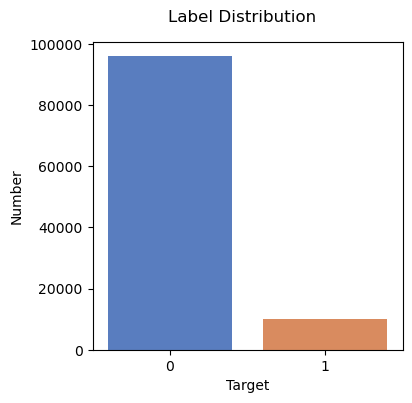

In [17]:
plot_label_dist(train_set, config['data_source']['target_name'])

### Random Under Sampling (RUS)

In [18]:
def rus_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    rus = RandomUnderSampler(random_state = config['data_source']['random_state'])

    x_rus, y_rus = rus.fit_resample(set_data.drop(config['data_source']['target_name'], axis = 1), 
                                    set_data[config['data_source']['target_name']])
    set_data_rus = pd.concat([x_rus, y_rus], axis = 1)
    return set_data_rus

In [19]:
train_set_rus = rus_fit_resample(train_set)

In [20]:
train_set_rus[config['data_source']['target_name']].value_counts()

0    9906
1    9906
Name: class, dtype: int64

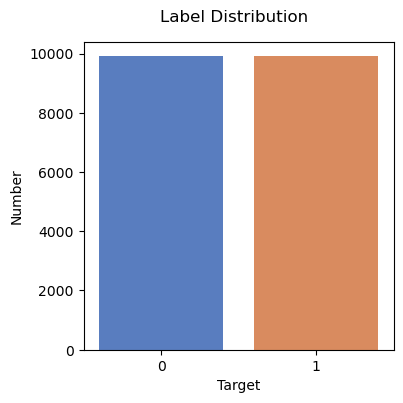

In [21]:
plot_label_dist(train_set_rus, config['data_source']['target_name'])

### Random Over Sampling (ROS)

In [22]:
def ros_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    ros = RandomOverSampler(random_state = config['data_source']['random_state'])

    x_ros, y_ros = ros.fit_resample(set_data.drop(config['data_source']['target_name'], axis = 1), 
                                    set_data[config['data_source']['target_name']])
    set_data_ros = pd.concat([x_ros, y_ros], axis = 1)
    return set_data_ros

In [23]:
train_set_ros = ros_fit_resample(train_set)

In [24]:
train_set_ros[config['data_source']['target_name']].value_counts()

0    95872
1    95872
Name: class, dtype: int64

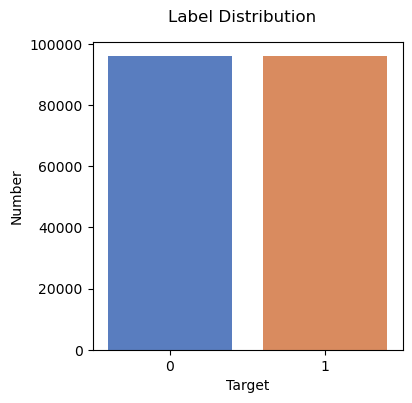

In [25]:
plot_label_dist(train_set_ros, config['data_source']['target_name'])

### Synthetic Minority Over-sampling Technique (SMOTE)

In [26]:
def smote_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    sm = SMOTE(random_state = config['data_source']['random_state'])

    x_sm, y_sm = sm.fit_resample(set_data.drop(config['data_source']['target_name'], axis = 1),
                                 set_data[config['data_source']['target_name']])
    set_data_sm = pd.concat([x_sm, y_sm], axis = 1)
    return set_data_sm

In [27]:
train_set_smote = smote_fit_resample(train_set)

In [28]:
train_set_smote[config['data_source']['target_name']].value_counts()

0    95872
1    95872
Name: class, dtype: int64

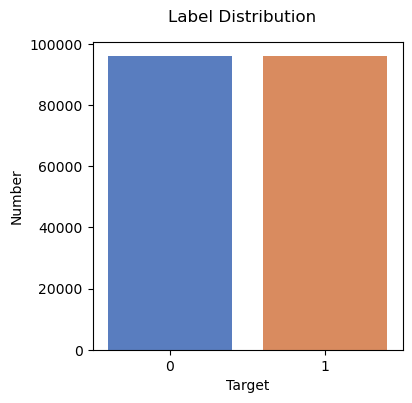

In [29]:
plot_label_dist(train_set_smote, config['data_source']['target_name'])

## Dump Data 

In [30]:
X_train = {
    'WithoutResampling' : train_set.drop(columns = config['data_source']['target_name']),
    'Undersampling' : train_set_rus.drop(columns = config['data_source']['target_name']),
    'Oversampling' : train_set_ros.drop(columns = config['data_source']['target_name']),
    'SMOTE' : train_set_smote.drop(columns = config['data_source']['target_name'])
}

y_train = {
    'WithoutResampling' : train_set[config['data_source']['target_name']],
    'Undersampling' : train_set_rus[config['data_source']['target_name']],
    'Oversampling' : train_set_ros[config['data_source']['target_name']],
    'SMOTE' : train_set_smote[config['data_source']['target_name']]
}

In [31]:
X_train_feng_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train_feng']
y_train_feng_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_train_feng']

X_test_feng_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_test_feng']
y_test_feng_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_test_feng']

# dump train data
util.pickle_dump(X_train, X_train_feng_path)
util.pickle_dump(y_train, y_train_feng_path)

# dump test data
util.pickle_dump(test_set.drop(columns = config['data_source']['target_name']), X_test_feng_path)
util.pickle_dump(test_set[config['data_source']['target_name']], y_test_feng_path)

In [32]:
X_train['WithoutResampling']

,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,sex_F,sex_M,age,purchase_value
61049,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,31,42
141787,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,32,38
84407,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,36,12
115800,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,19,12
61857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,28,41
...,...,...,...,...,...,...,...,...,...,...,...,...
79502,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,31,52
137723,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,30,46
13126,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,49,21
22089,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19,26


In [33]:
train_set

,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,sex_F,sex_M,age,purchase_value,class
61049,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,31,42,0
141787,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,32,38,0
84407,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,36,12,0
115800,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,19,12,0
61857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,28,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79502,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,31,52,0
137723,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,30,46,0
13126,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,49,21,0
22089,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19,26,0


In [34]:
test_set

,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,sex_F,sex_M,age,purchase_value,class
105758,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,27,50,0
106344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,43,60,0
15938,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,27,24,0
128784,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35,34,0
131719,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,22,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72707,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,48,17,0
139565,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,30,11,0
39855,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,47,57,0
9232,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,26,53,0
